In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
import survivors.datasets as ds
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

In [15]:
import survivors.datasets as ds
import warnings
warnings.filterwarnings("ignore")

X, y, features, categ, sch_nan = ds.load_pbc_dataset()

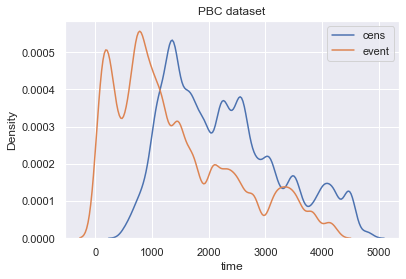

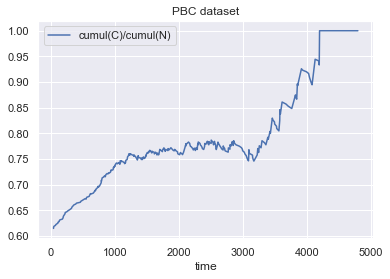

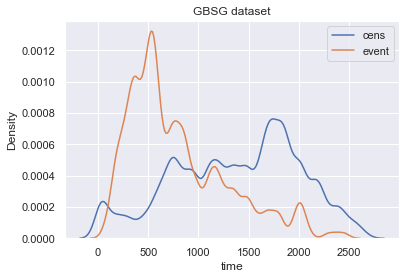

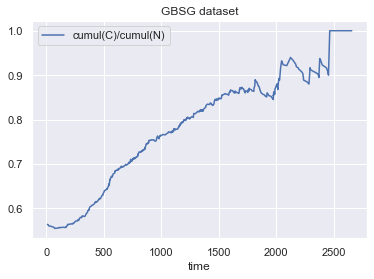

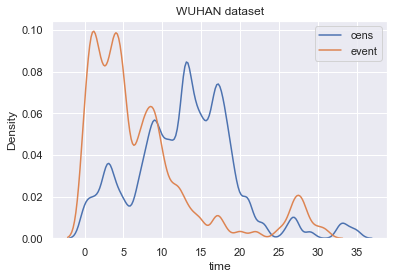

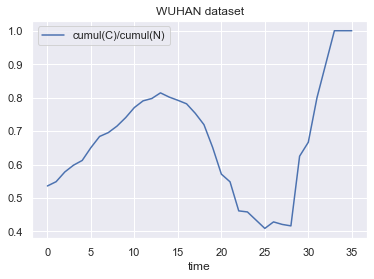

DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


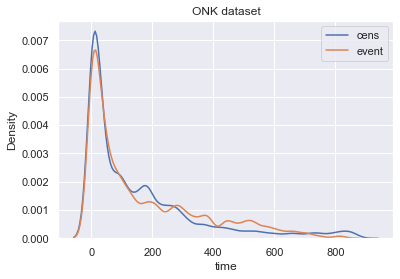

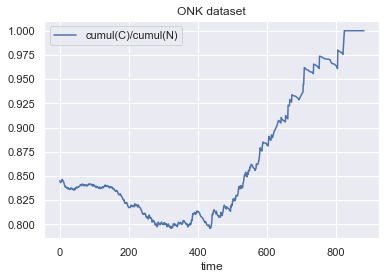

Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


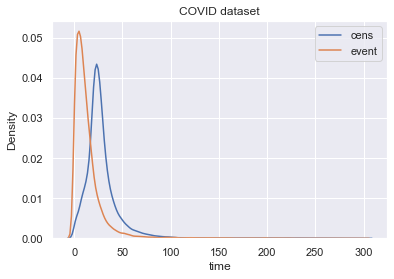

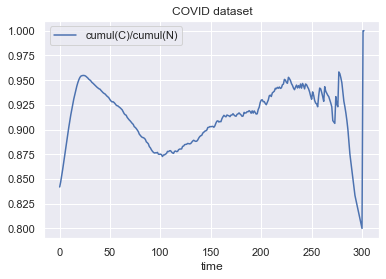

In [87]:
def plot_time_distr(v, label):
    sns.kdeplot(v[~v["cens"]]["time"],label="cens", bw=0.1)
    sns.kdeplot(v[v["cens"]]["time"], label="event", bw=0.1)
    plt.title(f"{label} dataset")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    
def plot_cens_ratio(v, label):
    time = np.searchsorted(np.unique(v["time"]), v["time"])
    time_hist = np.bincount(time)
    cens_hist = np.bincount(time, weights=1-v["cens"])
    N = np.cumsum(time_hist[::-1])[::-1]
    C = np.cumsum(cens_hist[::-1])[::-1]
    plt.plot(np.unique(v["time"]), C/N, label="cumul(C)/cumul(N)")
    #plt.scatter(np.unique(v["time"]), cens_hist/time_hist, label="C/N")
    plt.title(f"{label} dataset")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    
X, y, features, categ, sch_nan = ds.load_pbc_dataset()
plot_time_distr(y, "PBC")
plot_cens_ratio(y, "PBC")
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
plot_time_distr(y, "GBSG")
plot_cens_ratio(y, "GBSG")
X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
plot_time_distr(y, "WUHAN")
plot_cens_ratio(y, "WUHAN")
X, y, features, categ, sch_nan = ds.load_onk_dataset()
plot_time_distr(y, "ONK")
plot_cens_ratio(y, "ONK")
X, y, features, categ, sch_nan = ds.load_covid_dataset()
plot_time_distr(y, "COVID")
plot_cens_ratio(y, "COVID")

In [91]:
from survivors.tree import KaplanMeier, NelsonAalen
    
class ModifKaplanMeier(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        max_time = max(durations[right_censor])
        right_censor = right_censor[durations <= max_time]
        durations = durations[durations <= max_time]
        
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])
    
class RudeModifKaplanMeier(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        
        only_cens = np.bincount(dur_, weights=right_censor*weights)
        self.hist_cens = np.bincount(dur_, weights=weights)
        self.hist_cens -= only_cens
        
        self.cumul_hist_dur = np.cumsum(self.hist_cens[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])
        
#         cumul_only_cens = np.cumsum(only_cens[::-1])[::-1]
#         self.survival_function_cens = np.hstack([1.0, np.cumprod((1.0 - only_cens / (cumul_only_cens)))])
        
        N = right_censor.shape[0]
        Ncens = right_censor[~right_censor].shape[0]
        self.survival_function = Ncens/N + (1 - Ncens/N)*self.survival_function
        
class ModifNelsonAalen(NelsonAalen):
    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)
        
        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        hist_cens = np.bincount(dur_, weights=right_censor*weights)
        cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        if self.smoothing and all(weights == 1):
            cumul_hist_dur = cumul_hist_dur.astype("int")
            hist_cens = hist_cens.astype("int")
            cum_ = np.cumsum(1.0 / np.arange(1, np.max(cumul_hist_dur) + 1))
            hf = cum_[cumul_hist_dur - 1] - np.where(cumul_hist_dur - hist_cens - 1 >= 0,
                                                     cum_[cumul_hist_dur - hist_cens - 1], 0)
        else:
            hf = hist_cens / cumul_hist_dur
        self.hazard_function = np.hstack([0.0, np.cumsum(hf)])
        self.survival_function = np.exp(-1*self.hazard_function)
        
    def survival_function_at_times(self, bins=None):
        hf = self.cumulative_hazard_at_times(times=bins)
        sf = np.exp(-1*hf)
        return sf

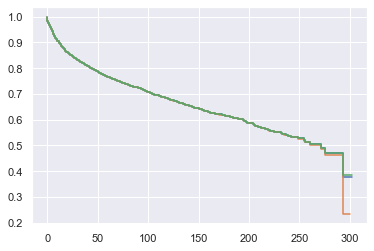

In [92]:
kmf = KaplanMeier()
kmf.fit(y["time"], y["cens"])
plt.step(np.hstack([0, kmf.timeline]), kmf.survival_function)

mkmf = ModifKaplanMeier()
mkmf.fit(y["time"], y["cens"])
plt.step(np.hstack([0, mkmf.timeline]), mkmf.survival_function)

mnaf = ModifNelsonAalen()
mnaf.fit(y["time"], y["cens"])
plt.step(np.hstack([0, mnaf.timeline]), mnaf.survival_function)
plt.show()

In [75]:
ModifKaplanMeier().__class__.__name__

'ModifKaplanMeier'

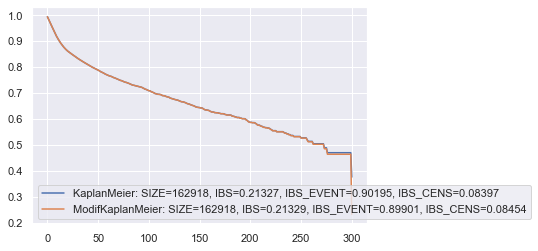

In [93]:
def plot_km_with_ibs(data, models=[]):
    bins = cnt.get_bins(data[cnt.TIME_NAME], 
                        cens=data[cnt.CENS_NAME])
    true_sf = cnt.get_y(data[cnt.CENS_NAME], data[cnt.TIME_NAME])
    
    for m in models:
        m_ins = m()
        m_ins.fit(data[cnt.TIME_NAME], data[cnt.CENS_NAME])
        sf_train = m_ins.survival_function_at_times(bins)

        pred_sf = np.repeat(sf_train[np.newaxis, :], data.shape[0], axis=0)
        ibs_val = round(metr.ibs(true_sf, true_sf, pred_sf, bins), 5)
        ibs_events = round(metr.ibs(true_sf, true_sf[true_sf["cens"]], pred_sf[true_sf["cens"]], bins), 5)
        ibs_cens = round(metr.ibs(true_sf, true_sf[~true_sf["cens"]], pred_sf[~true_sf["cens"]], bins), 5)
        plt.plot(bins, sf_train, 
                 label=f"{m_ins.__class__.__name__}: SIZE={data.shape[0]}, IBS={ibs_val}, IBS_EVENT={ibs_events}, IBS_CENS={ibs_cens}")
    plt.legend()
    plt.show()
    
plot_km_with_ibs(y, [KaplanMeier, ModifKaplanMeier])

In [ ]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier

""" Auxiliary functions """

def print_KM(left_time_hist, left_cens_hist, 
             right_time_hist, right_cens_hist, label=""):
    all_time = right_time_hist + left_time_hist
    all_cens = right_cens_hist + left_cens_hist
    
    cumul_all = np.cumsum(all_time[::-1])[::-1]
    survival_function_0 = np.hstack([1.0, np.cumprod((1.0 - all_cens / (cumul_all)))])
    plt.step(np.arange(len(survival_function_0)), survival_function_0, where='post', label=f'parent:{label}')
    
    cumul_hist_dur_1 = np.cumsum(left_time_hist[::-1])[::-1]
    survival_function_1 = np.hstack([1.0, np.cumprod((1.0 - left_cens_hist / (cumul_hist_dur_1)))])
    plt.step(np.arange(len(survival_function_1)), survival_function_1, where='post', label=f'left')
    
    cumul_hist_dur_2 = np.cumsum(right_time_hist[::-1])[::-1]
    survival_function_2 = np.hstack([1.0, np.cumprod((1.0 - right_cens_hist / (cumul_hist_dur_2)))])
    plt.step(np.arange(len(survival_function_2)), survival_function_2, where='post', label=f'right')
    plt.legend()


@njit('f4(u4[:], u4[:], u4[:], u4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    
    res[:, 0] = 1.0
    if weightings > 10:
        weightings -= 10
        res[:, 1] = np.abs(res[:, 1])
    
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
        # Empirical
    elif weightings == 6:
        res[:, 0] = O_j
    elif weightings == 7:
        res[:, 0] = 1/O_j
    elif weightings == 8:
        res[:, 0] = np.cumsum(O_j[::-1])[::-1]
    elif weightings == 9:
        s_O_j = np.cumsum(O_j[::-1])[::-1]
        res[:, 0] = 1/s_O_j
    elif weightings == 10:
        res[:, 0] = O_j/N_j
    stat_val = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2] ).sum())
    return stat_val # np.sqrt(stat_val)


def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"O_j": 6, "1/O_j": 7, "cumul_O_j": 8, "1/cumul_O_j": 9})
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("uint32"),
                                    time_hist_2.astype("uint32"),
                                    cens_hist_1.astype("uint32"),
                                    cens_hist_2.astype("uint32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
        return 0.0


def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef):
    none_to = 0
    max_stat_val = 1.0
    
    if dis_coef > 1:
        left_time_hist = left_time_hist + (dis_coef - 1)*left_cens_hist
        right_time_hist = right_time_hist + (dis_coef - 1)*right_cens_hist
        na_time_hist = na_time_hist + (dis_coef - 1)*na_cens_hist
        
        left_cens_hist = left_cens_hist*dis_coef
        right_cens_hist = right_cens_hist*dis_coef
        na_cens_hist = na_cens_hist*dis_coef
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist, right_time_hist,
                             left_cens_hist + na_cens_hist, right_cens_hist,
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist, right_time_hist + na_time_hist,
                             left_cens_hist, right_cens_hist + na_cens_hist,
                             weights_hist, weightings=criterion)
        
        none_to = int(a < b)
        max_stat_val = max(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist, right_time_hist,
                                        left_cens_hist, right_cens_hist,
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((p_bd - p_bd_)*woe_pl).sum()
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength).astype("int32")
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        # elif type_attr == "categ":
        #     best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=1, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    dis_coef = max(1, (cens.shape[0] - np.sum(cens)) // np.sum(cens))
    # print("dis_coef:", dis_coef)

    dur = split_time_to_bins(dur)
    max_bin = dur.max()

    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind], minlength=max_bin + 1)
    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna, minlength=max_bin + 1)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.int32)
    l_cens_hist = l_time_hist.copy()

    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1e-5)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif weights is None:
        weights_hist = None
    else:
        weights_hist = np.bincount(dur, weights=weights,  # /sum(weights),
                                   minlength=max_bin + 1)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]  # np.sqrt()
        # weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask],
                                                      cens_notna[curr_mask],
                                                      minlength=max_bin + 1)
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef)

        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    if verbose > 0:
        print(best_attr["stat_val"], best_attr["p_value"], len(uniq_set))
    return best_attr